# Решение проекта 4 Гвоздевой Александры

In [3]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
import re

In [5]:
%matplotlib inline

In [6]:
data=pd.read_csv('query_result_5.csv')

# Описание колонок полученного датасета:
    flight_id - уникальный номер рейса
    total_sum - выручка в рублях за данный рейс
    number_of_passengers - количество пассажиров на данном рейсе
    number_of_seats - количество мест в самолете на данном рейсе
    fill_up - заполняемость рейса в долях единицы (посчитано в Metabase как number_of_passengers/number_of_seats)
    model - модель самолета на данном рейсе
    flight_no - идентификатор рейса, состоящий из букв и цифр. Не является уникальным.
    departure_aiport - аэропорт отправления. В данном датасете это всегда Анапа
    arrival_airport - аэропорт прибытия
    aircraft_code - идентификатор самолета, на котором был совершен рейс
    actual_departure - фактическое время вылета 
    actual_arrival - фактическое время прилета
    length_of_flight - фактическое время пребывания самолета в воздухе

# Приступаем к анализу полученного датасета. 
Прежде всего проверяем количество уникальных номеров рейсов (flight_id) - 127.
Это именно столько, сколько было нам дано по условию задачи. Хочу отметить, что такой результат был получен при использовании LEFT JOIN таблицы flights с таблицей ticket_flights. Если использовать обычный JOIN, то результатов получится всего 118. Это происходит потому, что не все flight_id отражены в таблице ticket_flights. Другими словами, у нас нет информации о билетах на 9 из 127 рейсов из Анапы, которые нас интересуют. Мы не знаем, сколько было куплено билетов на эти рейсы и по какой стоимости. Мы не можем посчитать общую выручку от продажи билетов на эти 9 рейсов. Отсутствие информации отражено в data.info() в колонке total_sum, где мы видим 9 пропусков.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             127 non-null    int64  
 1   total_sum             118 non-null    float64
 2   number_of_passengers  127 non-null    int64  
 3   number_of_seats       127 non-null    int64  
 4   fill_up               127 non-null    float64
 5   model                 127 non-null    object 
 6   flight_no             127 non-null    object 
 7   departure_airport     127 non-null    object 
 8   arrival_airport       127 non-null    object 
 9   aircraft_code         127 non-null    object 
 10  actual_departure      127 non-null    object 
 11  actual_arrival        127 non-null    object 
 12  length_of_flight      127 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 13.0+ KB


In [18]:
data["flight_id"].nunique()

127

Приглядимся повнимательнее к данным с пропусками. Очевидно, что number_of_passengers в строках с пропусками, как и fill_up, 
не имеет никакого физического смысла. Единицы на месте количества пассажиров были получены в результате работы оконной функции count, которая посчитала количество строк в группе с данным flight_id (см. запрос SQL). Строки с пропусками можно просто удалить, т.к. никакой полезной информации для решения нашей задачи мы из них не получим.

In [17]:
data[data["total_sum"].isna()==True]

,flight_id,total_sum,number_of_passengers,number_of_seats,fill_up,model,flight_no,departure_airport,arrival_airport,aircraft_code,actual_departure,actual_arrival,length_of_flight
59,136511,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-02-21T06:15:00Z,2017-02-21T11:25:00Z,05:10:00
60,136513,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-02-28T06:13:00Z,2017-02-28T11:23:00Z,05:10:00
61,136514,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-02-07T06:14:00Z,2017-02-07T11:13:00Z,04:59:00
62,136523,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-01-10T06:14:00Z,2017-01-10T11:26:00Z,05:12:00
63,136540,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-01-17T06:14:00Z,2017-01-17T11:21:00Z,05:07:00
64,136544,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-01-31T06:10:00Z,2017-01-31T11:14:00Z,05:04:00
65,136546,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-01-03T06:13:00Z,2017-01-03T11:15:00Z,05:02:00
66,136560,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-01-24T06:13:00Z,2017-01-24T11:18:00Z,05:05:00
67,136567,NaN,1,130,0.007692,Boeing 737-300,PG0194,AAQ,NOZ,733,2017-02-14T06:12:00Z,2017-02-14T11:23:00Z,05:11:00


In [8]:
data.dropna(axis=0, inplace=True)

In [24]:
data.shape

(118, 13)

Для полноценного анализа данных нам не хватает:
    1. Стоимости топлива (fuel_cost)
    2. Расхода топлива в час для каждой модели самолета (fuel_consumption)
    3. Количества экипажа для каждой модели самолета (crew_number)
    4. Почасовой оплаты работы каждого члена экипажа (crew_salary)
    5. Стоимости ежедневного обслуживания каждой модели самолета (service_cost)
    6. Стоимости порции питания на борту самолета (food_cost)
    
Если бы мы все это знали, мы бы посчитали выручку с каждого рейса следующим образом:

flight_revenue=total_sum - (fuel_cost x fuel_consumption x duration_of_flight + crew_number x crew_salary + service_cost +
                             food_cost x number_of_passengers)

Посмотрим на количество перелетов по разным направлениям.

In [39]:
data.groupby("arrival_airport")["flight_id"].count()

arrival_airport
EGO    59
SVO    59
Name: flight_id, dtype: int64

Видим, что было совершено 59 перелетов в Москву и 59 - в Белгород. Перелеты в Белгород всегда проходят на самолете 
Sukhoi Superjet-100 с количеством мест 97. Перелеты в Москву - на самолете Boeing 737-300 с количеством мест 130.

In [39]:
data.groupby(["arrival_airport","model","flight_no"])["flight_id"].count()

arrival_airport  model                flight_no
EGO              Sukhoi Superjet-100  PG0480       59
SVO              Boeing 737-300       PG0252       59
Name: flight_id, dtype: int64

Сравним наполняемость рейсов по различным направлениям

Наполняемость рейсов по направлению "Белгород" в среднем чуть выше, чем по направлению "Москва".

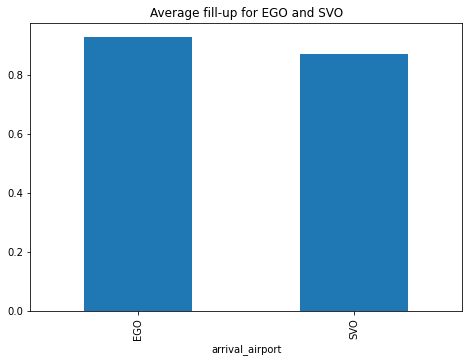

In [43]:
fig=plt.figure()
axes=fig.add_axes([0,0,1,1])
data.groupby("arrival_airport")["fill_up"].mean().plot(kind='bar', ax=axes)
axes.set_title('Average fill-up for EGO and SVO')
plt.show()

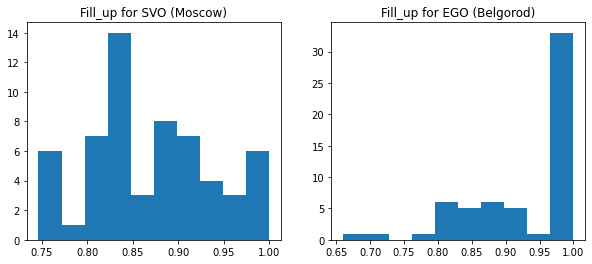

In [47]:
fig,axes=plt.subplots(1,2, figsize=(10,4))
SVO=data[data["arrival_airport"]=='SVO']
axes[0].hist(SVO["fill_up"])
axes[0].set_title('Fill_up for SVO (Moscow)')

EGO=data[data["arrival_airport"]=='EGO']
axes[1].hist(EGO["fill_up"])
axes[1].set_title('Fill_up for EGO (Belgorod)')

plt.show()

Проверим, сколько в базе рейсов с низкой наполняемостью (менее 75%) по каждому направлению

In [50]:
SVO_little=len(data[(data["arrival_airport"]=='SVO')&(data["fill_up"]<0.75)])
EGO_little=len(data[(data["arrival_airport"]=='EGO')&(data["fill_up"]<0.75)])
print("Рейсов в Москву с низкой наполняемостью: {0}\nРейсов в Белгород с низкой наполняемостью: {1}".format(SVO_little,EGO_little))

Рейсов в Москву с низкой наполняемостью: 2
Рейсов в Белгород с низкой наполняемостью: 2


Сравним доход от продажи билетов по различным направлениям.

Как мы видим, направление "Белгород" менее прибыльное, чем направление "Москва".

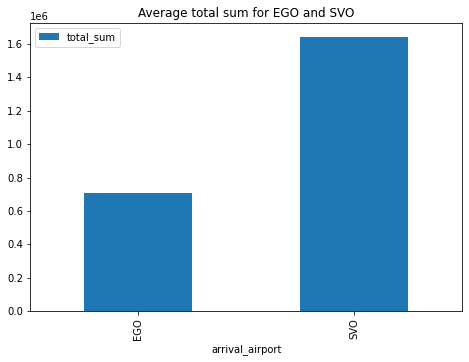

In [41]:
fig=plt.figure()
axes=fig.add_axes([0,0,1,1])
data.pivot_table(values=["total_sum"], index="arrival_airport", aggfunc="mean").plot(kind='bar', ax=axes)
axes.set_title('Average total sum for EGO and SVO')
plt.show()

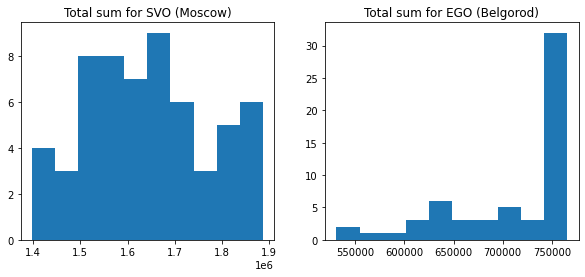

In [34]:
fig,axes=plt.subplots(1,2,figsize=(10,4))
SVO=data[data["arrival_airport"]=='SVO']
axes[0].hist(SVO["total_sum"])
axes[0].set_title("Total sum for SVO (Moscow)")

EGO=data[data["arrival_airport"]=='EGO']
axes[1].hist(EGO["total_sum"])
axes[1].set_title("Total sum for EGO (Belgorod)")

plt.show()

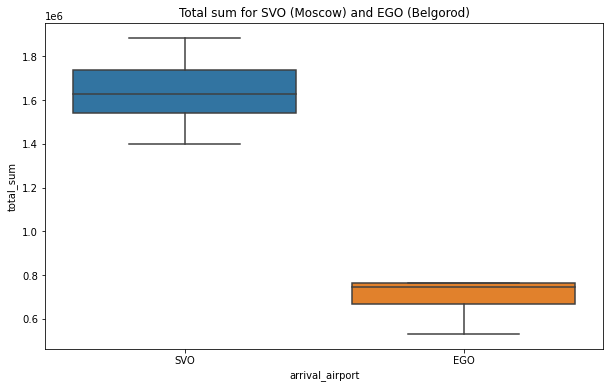

In [12]:
fig,ax=plt.subplots(figsize=(10,6))
sns.boxplot(x=data["arrival_airport"], y=data["total_sum"], data=data, ax=ax)
ax.set_title('Total sum for SVO (Moscow) and EGO (Belgorod)')
plt.show()

# Выводы.
1. Нами был получен датасет, включающий 127 записей о рейсах из Анапы в зимнее время года. Датасет содержат пропуски, связанные с использованием LEFT JOIN. Пропуски были удалены, т.к. никакой полезной информации извлечь из них не получится.
2. Для полноценного анализа данных не хватает информации о расходах на каждый рейс. Была предложена формула, с помощью которой эти расходы можно посчитать. Необходимо привлекать данные из сторонних источников для проведения расчета. Расчет реализован в дополнительном задании к данному проекту.
3. Анализ данных показал, что было совершено равное количество рейсов в Москву и Белгород (59). Прибыльность рейсов в Москву в среднем выше прибыльности рейсов в Белгород. Заполняемость рейсов в Белгород при этом несколько выше заполняемости рейсов в Москву.
4. Были  найдены 4 рейса с заполняемостью ниже 75% (2 в Москву и 2 в Белгород). Эти рейсы будут удалены в дополнительном задании к проекту.